In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


In [77]:
train_data = pd.read_csv("customer_Train.csv", index_col=0)
test_data = pd.read_csv("customer_Test.csv", index_col=0)
train_data.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
ID,,,,,,,,,,
462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [78]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8068 entries, 462809 to 461879
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           8068 non-null   object 
 1   Ever_Married     7928 non-null   object 
 2   Age              8068 non-null   int64  
 3   Graduated        7990 non-null   object 
 4   Profession       7944 non-null   object 
 5   Work_Experience  7239 non-null   float64
 6   Spending_Score   8068 non-null   object 
 7   Family_Size      7733 non-null   float64
 8   Var_1            7992 non-null   object 
 9   Segmentation     8068 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 693.3+ KB


In [79]:
train_data.describe()

,Age,Work_Experience,Family_Size
count,8068.000000,7239.000000,7733.000000
mean,43.466906,2.641663,2.850123
std,16.711696,3.406763,1.531413
min,18.000000,0.000000,1.000000
25%,30.000000,0.000000,2.000000
50%,40.000000,1.000000,3.000000
75%,53.000000,4.000000,4.000000
max,89.000000,14.000000,9.000000


In [80]:
data.isna().sum()

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
dtype: int64

In [81]:
print('Entrées dupliquées: {}'.format(data.duplicated().sum()))
data.drop_duplicates(inplace = True)

Entrées dupliquées: 0


In [82]:
train_data.isnull().sum()

Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [83]:
cat_data = train_data.select_dtypes(include="object")
for var in cat_data:
    print(f"{var} (n={len(cat_data[var].unique())}):")
    print(cat_data[var].value_counts(normalize=True))


Gender (n=2):
Male      0.547471
Female    0.452529
Name: Gender, dtype: float64
Ever_Married (n=3):
Yes    0.585646
No     0.414354
Name: Ever_Married, dtype: float64
Graduated (n=3):
Yes    0.621777
No     0.378223
Name: Graduated, dtype: float64
Profession (n=10):
Artist           0.316717
Healthcare       0.167674
Entertainment    0.119461
Engineer         0.087991
Doctor           0.086606
Lawyer           0.078424
Executive        0.075403
Marketing        0.036757
Homemaker        0.030967
Name: Profession, dtype: float64
Spending_Score (n=3):
Low        0.604611
Average    0.244670
High       0.150719
Name: Spending_Score, dtype: float64
Var_1 (n=8):
Cat_6    0.655405
Cat_4    0.136261
Cat_3    0.102853
Cat_2    0.052803
Cat_7    0.025400
Cat_1    0.016642
Cat_5    0.010636
Name: Var_1, dtype: float64
Segmentation (n=4):
D    0.281111
A    0.244422
C    0.244175
B    0.230293
Name: Segmentation, dtype: float64


In [84]:
train_data.describe(include="object")

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
count,8068,7928,7990,7944,8068,7992,8068
unique,2,2,2,9,3,7,4
top,Male,Yes,Yes,Artist,Low,Cat_6,D
freq,4417,4643,4968,2516,4878,5238,2268


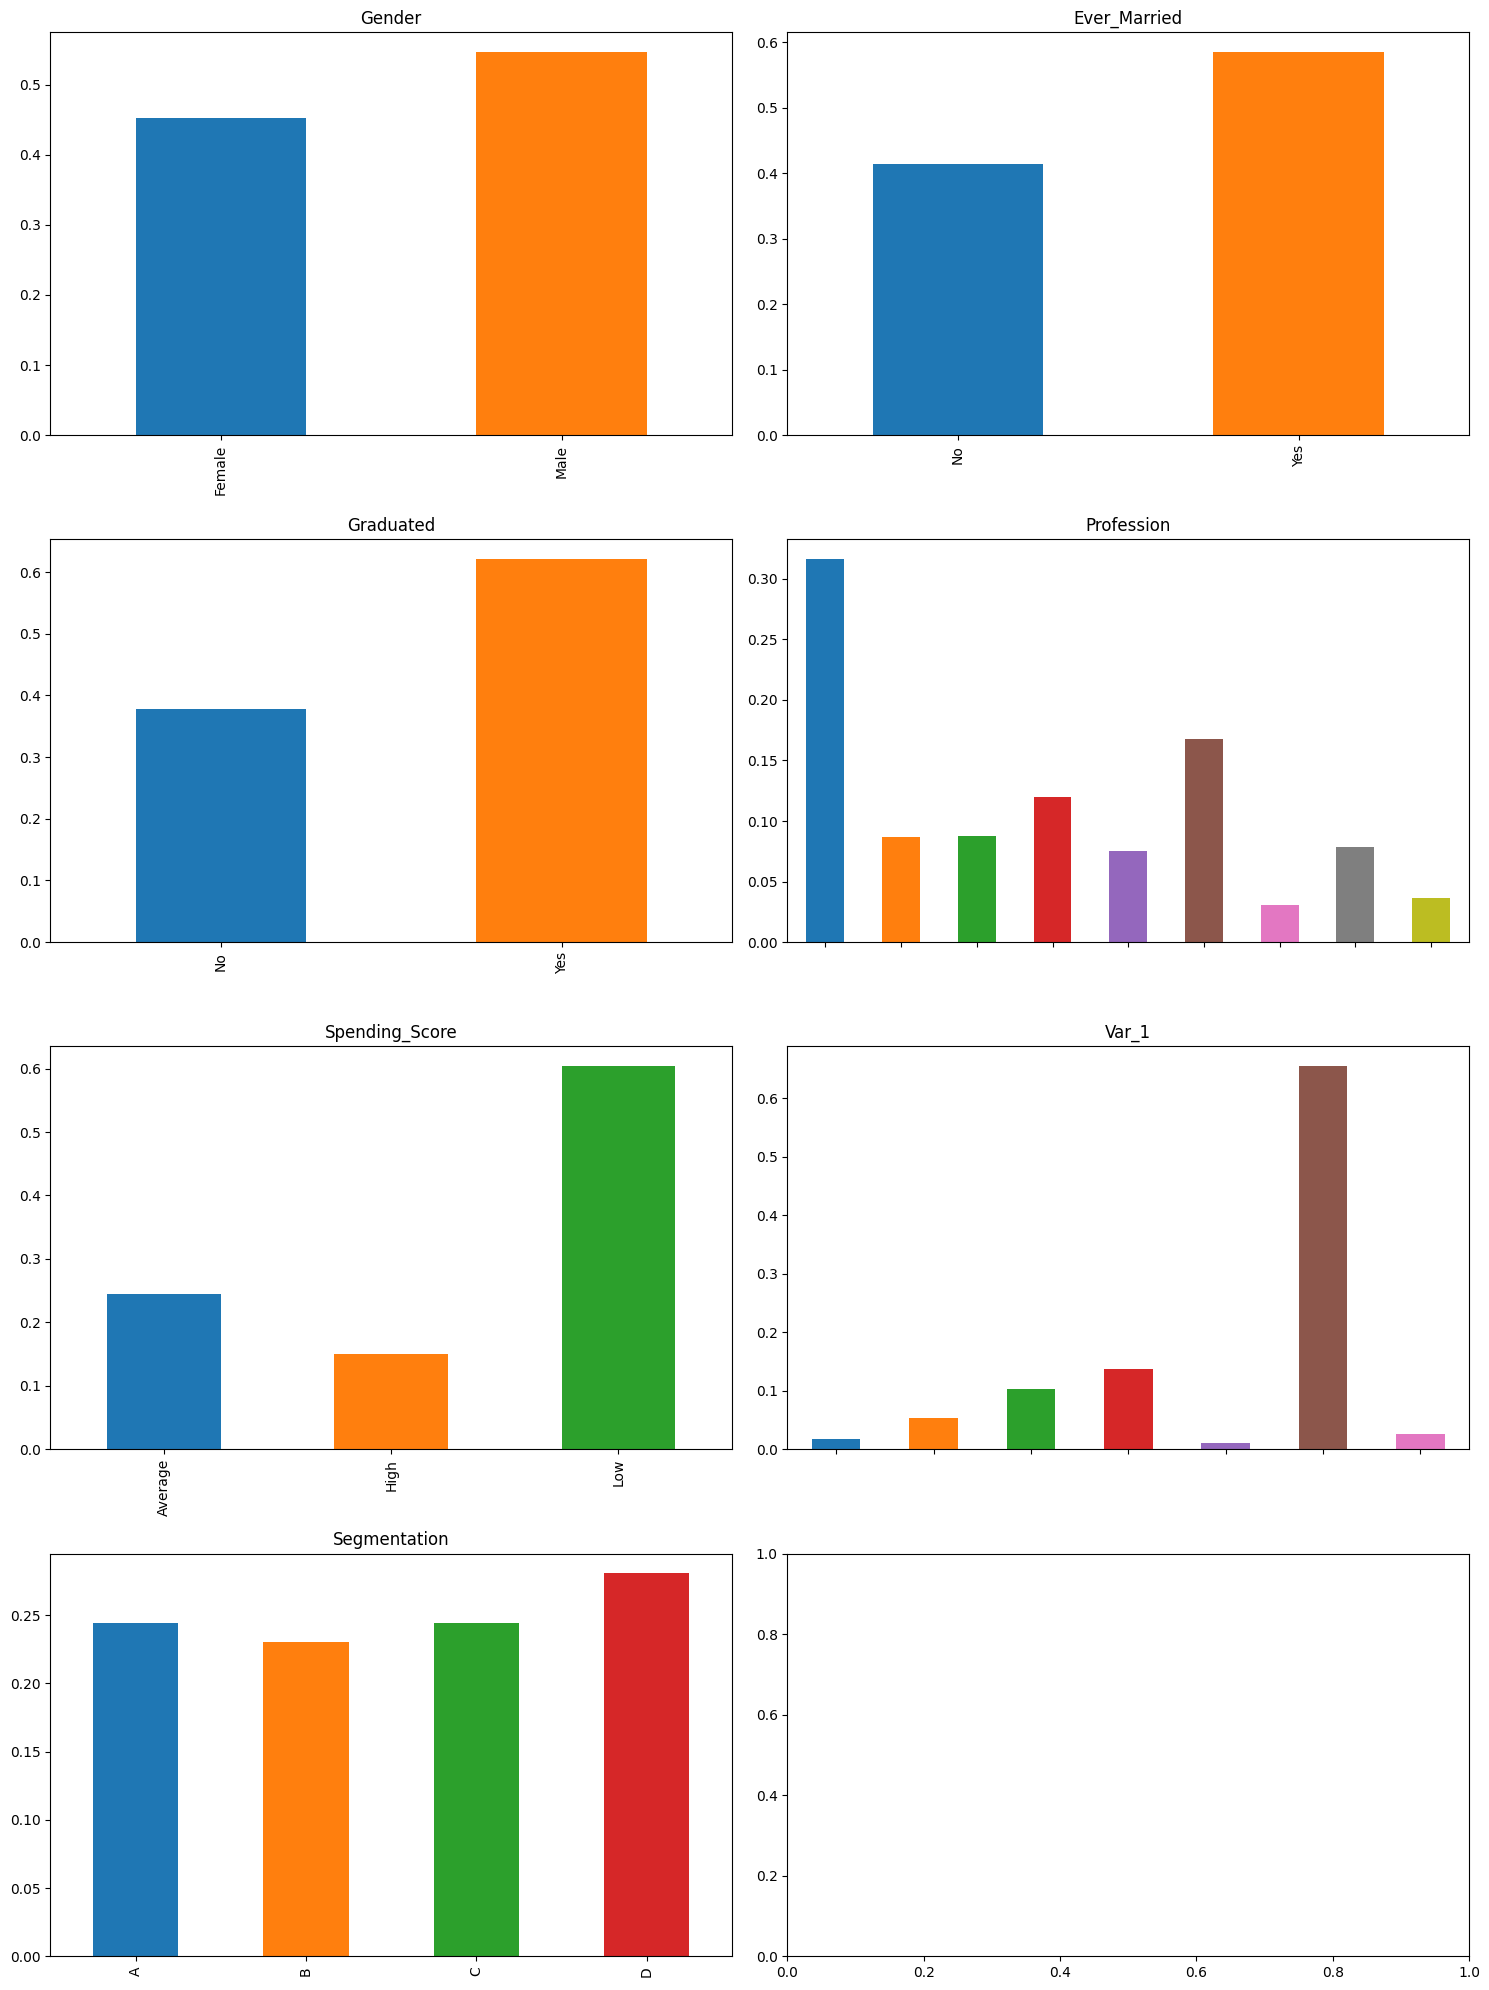

In [85]:
cat_data = train_data.select_dtypes(include="object")

num_cols = 2
num_rows = int(np.ceil(cat_data.shape[1] / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows*5))
axes = axes.flatten()

for i, col in enumerate(cat_data.columns):
    cat_counts = cat_data[col].value_counts(normalize=True).sort_index()
    cat_counts.plot(kind='bar', stacked=True, ax=axes[i], color=sns.color_palette())
    axes[i].set_title(col)

    # hide x-axis labels if there are too many categories
    if len(cat_counts) > 5:
        axes[i].tick_params(axis='x', which='both', labelbottom=False)

plt.tight_layout()
plt.show()


In [86]:
def remove_outliers(data, cols):
    q1 = data[cols].quantile(0.25)
    q3 = data[cols].quantile(0.75)
    iqr = q3 - q1

    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr

    return data[~((data[cols] < lower_bound) | (data[cols] > upper_bound)).any(axis=1)]

# remove outliers from train_df and test_df
num_df = train_data.select_dtypes(include=np.number)
train_data = remove_outliers(train_data, num_df.columns)
test_data = remove_outliers(test_data, num_df.columns)

# check the number of rows before and after outlier removal
print("Before outlier removal: ", len(num_df))
print("After outlier removal: ", len(train_data))


Before outlier removal:  8068
After outlier removal:  7720


In [89]:


# Separate the target variable from the input features
X_train = train_data.drop(columns="Segmentation")
y_train = train_data["Segmentation"]
X_test = test_data.drop(columns="Segmentation")
y_test = test_data["Segmentation"]

# Identify numerical and categorical columns
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

# Preprocessing pipeline for numerical features
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
])

# Preprocessing pipeline for categorical features
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
])

# ColumnTransformer to apply the appropriate preprocessing pipeline to each column
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols),
])

# Define the K-Nearest Neighbors model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Construct the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', knn_model),
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print the classification report
report = classification_report(y_test, y_pred)
print(report)


Accuracy: 0.33134920634920634
              precision    recall  f1-score   support

           A       0.36      0.33      0.34       806
           B       0.24      0.25      0.25       527
           C       0.25      0.35      0.29       455
           D       0.48      0.38      0.42       732

    accuracy                           0.33      2520
   macro avg       0.33      0.33      0.33      2520
weighted avg       0.35      0.33      0.34      2520



In [90]:
X_train = train_data.dropna().drop(columns="Segmentation")
y_train = train_data.dropna()["Segmentation"]

X_test = test_data.dropna().drop(columns="Segmentation")
y_test = test_data.dropna()["Segmentation"]

cat_cols = ['Gender', 'Ever_Married', "Graduated", 'Profession', 'Spending_Score', "Var_1"]
cat_encoder = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat_encoder', cat_encoder, cat_cols)
    ],
    remainder="passthrough"
)

knn_model = KNeighborsClassifier(n_neighbors=5)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', knn_model)
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.32847424684159376


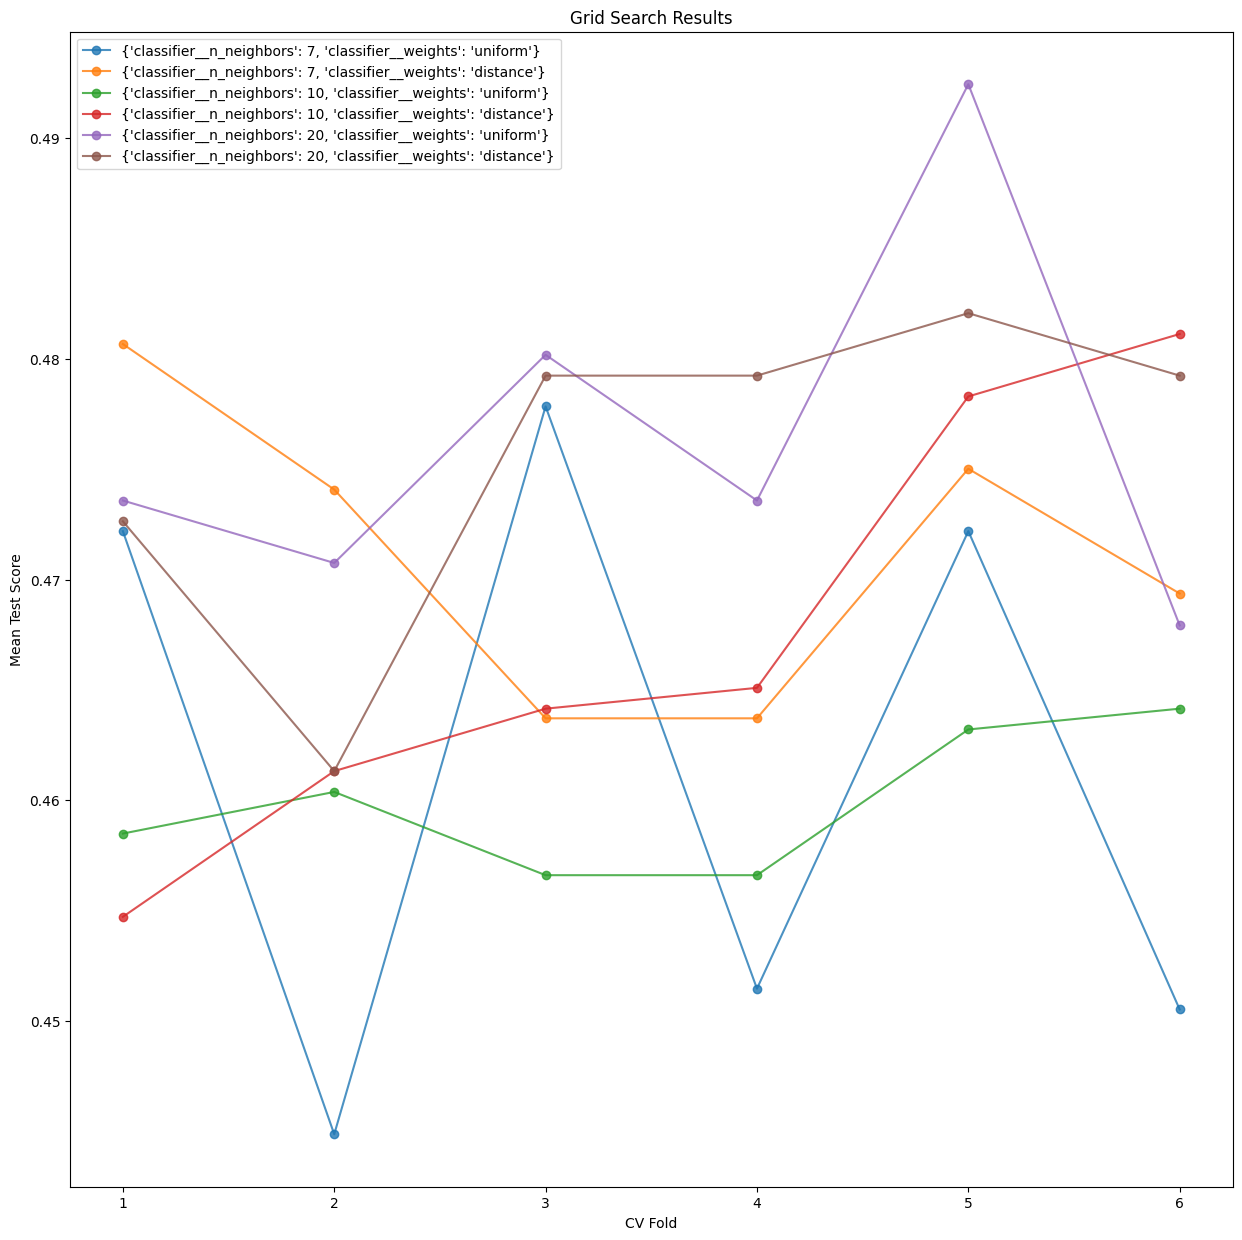

In [96]:
from sklearn.model_selection import GridSearchCV
X_train = train_data.dropna().drop(columns="Segmentation")
y_train = train_data.dropna()["Segmentation"]

X_test = test_data.dropna().drop(columns="Segmentation")
y_test = test_data.dropna()["Segmentation"]

cat_cols = ['Gender', 'Ever_Married', "Graduated", 'Profession', 'Spending_Score', "Var_1"]
cat_encoder = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat_encoder', cat_encoder, cat_cols)
    ],
    remainder="passthrough"
)

knn_model = KNeighborsClassifier()

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', knn_model)
])

param_grid = {
    'classifier__n_neighbors': [7, 10, 20],
    'classifier__weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=6, scoring='accuracy')

grid_search.fit(X_train, y_train)

cv_results = grid_search.cv_results_
param_grid = cv_results['params']
mean_test_scores = cv_results['mean_test_score']

plt.figure(figsize=(15, 15))
for i, params in enumerate(param_grid):
    plt.plot(range(1, len(mean_test_scores) + 1), cv_results[f'split{i}_test_score'], marker='o', label=f'{params}', alpha=0.8)

plt.title('Grid Search Results')
plt.xlabel('CV Fold')
plt.ylabel('Mean Test Score')
plt.legend(loc='best')
plt.show()


Accuracy: 0.3323615160349854


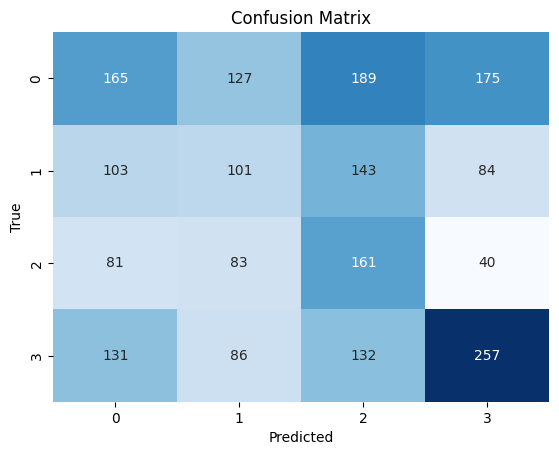

In [98]:
from sklearn.metrics import confusion_matrix

y_pred = grid_search.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


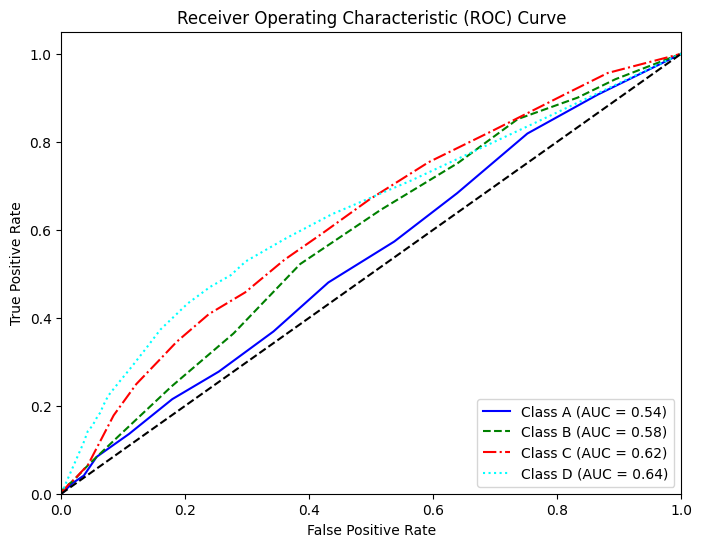

In [97]:
from sklearn.metrics import roc_curve, auc

y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
classes = list('ABCD')

for i, classe in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == classe, y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6)) # adjust figure size
colors = ['blue', 'green', 'red', 'cyan'] # change line colors
linestyles = ['-', '--', '-.', ':'] # change line styles
for i, classe in enumerate(classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], linestyle=linestyles[i%4], 
             label=f'Class {classe} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
